Given a textual document:
0. Apply some preprocessing to the words - choose between bag of words, TF.IDF, stemming, shingles...
1. Compute the histogram: count the occurences of the words
2. Compute the cosine similarity and output a ranking of the most similar elements.


# Env Set up

In [1]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!pip install pyspark
!pip install -q findspark
!pip show pyspark
!pip install memory_profiler
%load_ext memory_profiler

     |████████████████████████████████| 281.3 MB 38 kB/s 
     |████████████████████████████████| 198 kB 50.0 MB/s 
  Created wheel for pyspark: filename=pyspark-3.2.0-py2.py3-none-any.whl size=281805912 sha256=24e9447a92ce832f0fd59bced367fdcbbafdb7d4c8ed02668fc34bd2afe2a003
  Stored in directory: /root/.cache/pip/wheels/0b/de/d2/9be5d59d7331c6c2a7c1b6d1a4f463ce107332b1ecd4e80718
Successfully built pyspark
Name: pyspark
Version: 3.2.0
Summary: Apache Spark Python API
Home-page: https://github.com/apache/spark/tree/master/python
Author: Spark Developers
Author-email: dev@spark.apache.org
License: http://www.apache.org/licenses/LICENSE-2.0
Location: /usr/local/lib/python3.7/dist-packages
Requires: py4j
Required-by: 
  Created wheel for memory-profiler: filename=memory_profiler-0.58.0-py3-none-any.whl size=30190 sha256=8622e87063b16c95664f830ca9e7ad36d67e216cb31238a714a9b272030103ce
  Stored in directory: /root/.cache/pip/wheels/56/19/d5/8cad06661aec65a04a0d6785b1a5ad035cb645b1772a4a0882


In [2]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/usr/local/lib/python3.7/dist-packages/pyspark"

import pyspark
sc = pyspark.SparkContext("local[*]").getOrCreate()
sc

<SparkContext master=local[*] appName=pyspark-shell>

In [3]:
import findspark
findspark.init()

# Text Choice and Pre-processing
I will compute the similarities between [Shakespeare comedies](http://shakespeare.mit.edu/). 





In [4]:
!wget https://github.com/aliswh/architectures-for-big-data/raw/main/data/comedies.zip
!mkdir /content/comedies
!unzip /content/comedies.zip -d /content/comedies

--2021-11-14 18:29:22--  https://github.com/aliswh/architectures-for-big-data/raw/main/data/comedies.zip
Resolving github.com (github.com)... 52.192.72.89
Connecting to github.com (github.com)|52.192.72.89|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/aliswh/architectures-for-big-data/main/data/comedies.zip [following]
--2021-11-14 18:29:22--  https://raw.githubusercontent.com/aliswh/architectures-for-big-data/main/data/comedies.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2509186 (2.4M) [application/zip]
Saving to: ‘comedies.zip’

comedies.zip        100%[===================>]   2.39M  --.-KB/s    in 0.08s   

2021-11-14 18:29:23 (30.1 MB/s) - ‘comedies.zip’ saved [2509186/2509186]

A

In [5]:
import os
data_path = '/content/comedies/'
f"Total number of texts: {len(os.listdir(data_path))}"

'Total number of texts: 17'

In [6]:
import re

rdd_dict = {}
stem = '[0-9]*[!@#$%^&*_+=\-;:,.—<>?\'\/\\\ "()\[\]]+'

for text in os.listdir(data_path):
  text_name = re.sub('[\', -]+', '', text)
  file_path = data_path + text_name
  os.rename(data_path + text, file_path) 
  rdd_dict[text_name] = sc.textFile(file_path)

rdd_dict

{'AMidsummerNightsDream.txt': /content/comedies/AMidsummerNightsDream.txt MapPartitionsRDD[17] at textFile at NativeMethodAccessorImpl.java:0,
 'AllsWellThatEndsWell.txt': /content/comedies/AllsWellThatEndsWell.txt MapPartitionsRDD[13] at textFile at NativeMethodAccessorImpl.java:0,
 'AsYouLikeIt.txt': /content/comedies/AsYouLikeIt.txt MapPartitionsRDD[31] at textFile at NativeMethodAccessorImpl.java:0,
 'Cymbeline.txt': /content/comedies/Cymbeline.txt MapPartitionsRDD[33] at textFile at <unknown>:0,
 'LovesLaboursLost.txt': /content/comedies/LovesLaboursLost.txt MapPartitionsRDD[29] at textFile at NativeMethodAccessorImpl.java:0,
 'MeasureforMeasure.txt': /content/comedies/MeasureforMeasure.txt MapPartitionsRDD[3] at textFile at NativeMethodAccessorImpl.java:0,
 'MuchAdoaboutNothing.txt': /content/comedies/MuchAdoaboutNothing.txt MapPartitionsRDD[25] at textFile at NativeMethodAccessorImpl.java:0,
 'PericlesPrinceofTyre.txt': /content/comedies/PericlesPrinceofTyre.txt MapPartitionsRDD

In [7]:
for text in rdd_dict:
  print(text, rdd_dict[text].distinct().count()) # number of distinct words

TheTwoGentlemenofVerona.txt 2398
MeasureforMeasure.txt 2722
TheTamingoftheShrew.txt 2965
TheTempest.txt 2505
TheComedyofErrors.txt 2053
TheMerryWivesofWindsor.txt 1928
AllsWellThatEndsWell.txt 2655
TroilusandCressida.txt 3528
AMidsummerNightsDream.txt 2351
TheWintersTale.txt 3235
TwelfthNight;orWhatYouWill.txt 2160
TheMerchantofVenice.txt 2720
MuchAdoaboutNothing.txt 2031
PericlesPrinceofTyre.txt 2723
LovesLaboursLost.txt 2784
AsYouLikeIt.txt 2240
Cymbeline.txt 3949


Get number of occurences for each text

In [8]:
rdd_occurences = {}

for text in rdd_dict:
  rdd_dict[text] = rdd_dict[text].map(lambda x: re.sub(stem, " ", x)).flatMap(lambda x: x.split()).map(lambda x: x.lower()).map(lambda x: (x, 1)) 

for text in rdd_dict:
  rdd_occurences[text] = rdd_dict[text].reduceByKey(lambda x, y: x+y)
rdd_occurences['AMidsummerNightsDream.txt'].take(10)

[('shakespeare', 2),
 ('midsummer', 1),
 ('night', 51),
 ('s', 134),
 ('dream', 15),
 ('online', 1),
 ('library', 1),
 ('of', 268),
 ('oll', 1),
 ('libertyfund', 1)]

# More pre-processing: computing TF.IDF


Compute Term Frequency
> Occurence of term w.r.t. the most frequent term in the document

In [9]:
rdd_tf = {}

for text in rdd_occurences:
  max_term = rdd_occurences[text].max(lambda x: x[1]) # term with max frequency in the text
  rdd_tf[text] = rdd_occurences[text].map(lambda x: (x[0], x[1] / max_term[1]))
  print(f'{text} : {rdd_tf[text].count()}')

TheTwoGentlemenofVerona.txt : 2661
MeasureforMeasure.txt : 3246
TheTamingoftheShrew.txt : 3190
TheTempest.txt : 3122
TheComedyofErrors.txt : 2467
TheMerryWivesofWindsor.txt : 3224
AllsWellThatEndsWell.txt : 3423
TroilusandCressida.txt : 4127
AMidsummerNightsDream.txt : 2933
TheWintersTale.txt : 3750
TwelfthNight;orWhatYouWill.txt : 3063
TheMerchantofVenice.txt : 3181
MuchAdoaboutNothing.txt : 2921
PericlesPrinceofTyre.txt : 3175
LovesLaboursLost.txt : 3663
AsYouLikeIt.txt : 3199
Cymbeline.txt : 4075


In [10]:
rdd_tf['AMidsummerNightsDream.txt'].take(5)

[('shakespeare', 0.002068252326783868),
 ('midsummer', 0.001034126163391934),
 ('night', 0.052740434332988625),
 ('s', 0.13857290589451912),
 ('dream', 0.015511892450879007)]

Compute Inverse Document Frequency
> For each term, divide the total number of documents by the number of documents that contain that term

In [11]:
from math import log 
N = len(rdd_dict)

rdd_idf = sc.emptyRDD()
for text in rdd_dict:
  rdd_idf = rdd_idf.union(rdd_dict[text].distinct())
rdd_idf = rdd_idf.reduceByKey(lambda x,y: x+y).map(lambda x: (x[0], log(N/x[1])))
rdd_idf.count()

15845

In [12]:
rdd_idf.take(5)

[('home', 0.0),
 ('tender', 0.0),
 ('rare', 0.26826398659467937),
 ('happiness', 0.5306282510621704),
 ('dost', 0.0)]

Finally, compute TF.IDF

In [13]:
rdd_tf_idf = {}
rdd_tf_idf

for text in rdd_tf:
  rdd_tf_idf[text] = rdd_tf[text].join(rdd_idf).map(lambda x: (x[0], x[1][0]*x[1][1]))
  print(f'{text} : {rdd_tf_idf[text].count()}')

TheTwoGentlemenofVerona.txt : 2661
MeasureforMeasure.txt : 3246
TheTamingoftheShrew.txt : 3190
TheTempest.txt : 3122
TheComedyofErrors.txt : 2467
TheMerryWivesofWindsor.txt : 3224
AllsWellThatEndsWell.txt : 3423
TroilusandCressida.txt : 4127
AMidsummerNightsDream.txt : 2933
TheWintersTale.txt : 3750
TwelfthNight;orWhatYouWill.txt : 3063
TheMerchantofVenice.txt : 3181
MuchAdoaboutNothing.txt : 2921
PericlesPrinceofTyre.txt : 3175
LovesLaboursLost.txt : 3663
AsYouLikeIt.txt : 3199
Cymbeline.txt : 4075


In [14]:
rdd_tf_idf['AMidsummerNightsDream.txt'].takeOrdered(5, key=lambda x: -x[1]) # most important words in AMidsummerNightsDream.txt

[('lysander', 0.4453448069250722),
 ('demetrius', 0.4365551067883932),
 ('hermia', 0.4365551067883932),
 ('quince', 0.27834050432817015),
 ('theseus', 0.24786702203886488)]

## Remove unimportant words

In [15]:
importance_ = 0.01 # default 0.001

clean_rdd = {}
for text in rdd_tf_idf:
  clean_rdd[text] = rdd_occurences[text].join(rdd_tf_idf[text]).filter(lambda x: x[1][1] > importance_).map(lambda x: (x[0], x[1][0])) # keep the words with index > importance_
  print(f"From {text} we kept the {round((clean_rdd[text].count() / rdd_tf_idf[text].count()) * 100, 3)}% of the words, for a remaining total of {clean_rdd[text].count()} words")

From TheTwoGentlemenofVerona.txt we kept the 0.827% of the words, for a remaining total of 22 words
From MeasureforMeasure.txt we kept the 0.955% of the words, for a remaining total of 31 words
From TheTamingoftheShrew.txt we kept the 1.254% of the words, for a remaining total of 40 words
From TheTempest.txt we kept the 1.153% of the words, for a remaining total of 36 words
From TheComedyofErrors.txt we kept the 1.419% of the words, for a remaining total of 35 words
From TheMerryWivesofWindsor.txt we kept the 1.954% of the words, for a remaining total of 63 words
From AllsWellThatEndsWell.txt we kept the 0.935% of the words, for a remaining total of 32 words
From TroilusandCressida.txt we kept the 1.357% of the words, for a remaining total of 56 words
From AMidsummerNightsDream.txt we kept the 1.5% of the words, for a remaining total of 44 words
From TheWintersTale.txt we kept the 0.907% of the words, for a remaining total of 34 words
From TwelfthNight;orWhatYouWill.txt we kept the 1.0

In [16]:
clean_rdd['AMidsummerNightsDream.txt'].first() # most important words in AMidsummerNightsDream.txt AND their occurences in the text

('egeus', 23)

# Get matrix of occurences 

Take a unique RDD for all the terms that appear in the collection of comedies. 
1. fullOuterJoin every text RDD with occurences of the words to get a RDD of all the important words
2. because the join creates nested tuples, flatten the results to a list

In [17]:
def get_cosine_rdd(clean_rdd):
  cosine_rdd = sc.emptyRDD()
  for text in clean_rdd:
      cosine_rdd = cosine_rdd.fullOuterJoin(clean_rdd[text]) # if we want the occurences instead of the term presence
  return cosine_rdd

def flatten(term_occ):
    output = []
    for occ in term_occ:
        output += flatten(occ) if isinstance(occ, tuple) else [int(occ or 0)] 
    return output
find_candidates = get_cosine_rdd(clean_rdd).map(lambda x: (x[0], flatten(x[1])))
find_candidates.count()

620

In [18]:
find_candidates.take(3)

[('herne', [0, 11, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 ('queen', [0, 55, 0, 0, 0, 0, 0, 0, 93]),
 ('awaking', [0, 6, 0, 0, 0, 0, 0, 0, 0, 0])]

## Histogram

A histogram is computed on numerical data, in our case we compute it on the number of occurrences, so that we get the distribution of occurences divided into N bins. Each bin contains the number of values that fall into that numerical interval.

The default histogram function of PySpark: 

In [19]:
%%time
N = 5
print(find_candidates.map(lambda x : x[1]).map(lambda x : sum(x)).histogram(N))

([4.0, 197.6, 391.2, 584.8, 778.4, 972], [565, 45, 9, 0, 1])
CPU times: user 247 ms, sys: 58.7 ms, total: 306 ms
Wall time: 17.4 s


### My implementation:

1. First implementation: is faster if the data is little
2. Second implementation: it takes approx. the same time as the built-in histogram function, and it is distributed using accumulators as counters for the bins

N.B: the upper limit on the bins is not included in the interval. 

**TODO: only the last (max) occurence is not included in the overall computation, so its value gets lost**

In [20]:
%%time
rdd_f = find_candidates.map(lambda x : x[1]).map(lambda x : sum(x)) # sum all occurences across all texts
occ = rdd_f.collect() # PROBLEM!
MAX = max(occ) 
bins = {((i-1)*MAX//N, i*MAX//N):0 for i in range(1,N+1)} # Create N even intervals

for v in occ:
  for b in bins:
    if v in range(b[0],b[1]):
      bins[b]+=1
print(bins) 

{(0, 194): 562, (194, 388): 47, (388, 583): 10, (583, 777): 0, (777, 972): 0}
CPU times: user 128 ms, sys: 23.1 ms, total: 151 ms
Wall time: 8.57 s


In [21]:
%%time
rdd_f = find_candidates.map(lambda x : x[1]).map(lambda x : sum(x)) # sum all occurences across all texts
MAX = rdd_f.max() 
bins = {((i-1)*MAX//N, i*MAX//N):sc.accumulator(0) for i in range(1,N+1)} # Create N even intervals

def in_bins(x):
  print(x)
  for b in bins:
    if x in range(b[0],b[1]):
      bins[b] += 1
  return

rdd_f.map(in_bins).count()

print(bins)  

{(0, 194): Accumulator<id=0, value=562>, (194, 388): Accumulator<id=1, value=47>, (388, 583): Accumulator<id=2, value=10>, (583, 777): Accumulator<id=3, value=0>, (777, 972): Accumulator<id=4, value=0>}
CPU times: user 294 ms, sys: 48.6 ms, total: 342 ms
Wall time: 18.2 s


### Visualizing the most frequent words in all comedies via a plot

In [22]:
for_histogrom_rdd = find_candidates.map(lambda x: (x[0], sum(x[1]))).sortBy(lambda x: x[1], ascending=False)
for_histogrom_rdd.first()

('duke', 972)

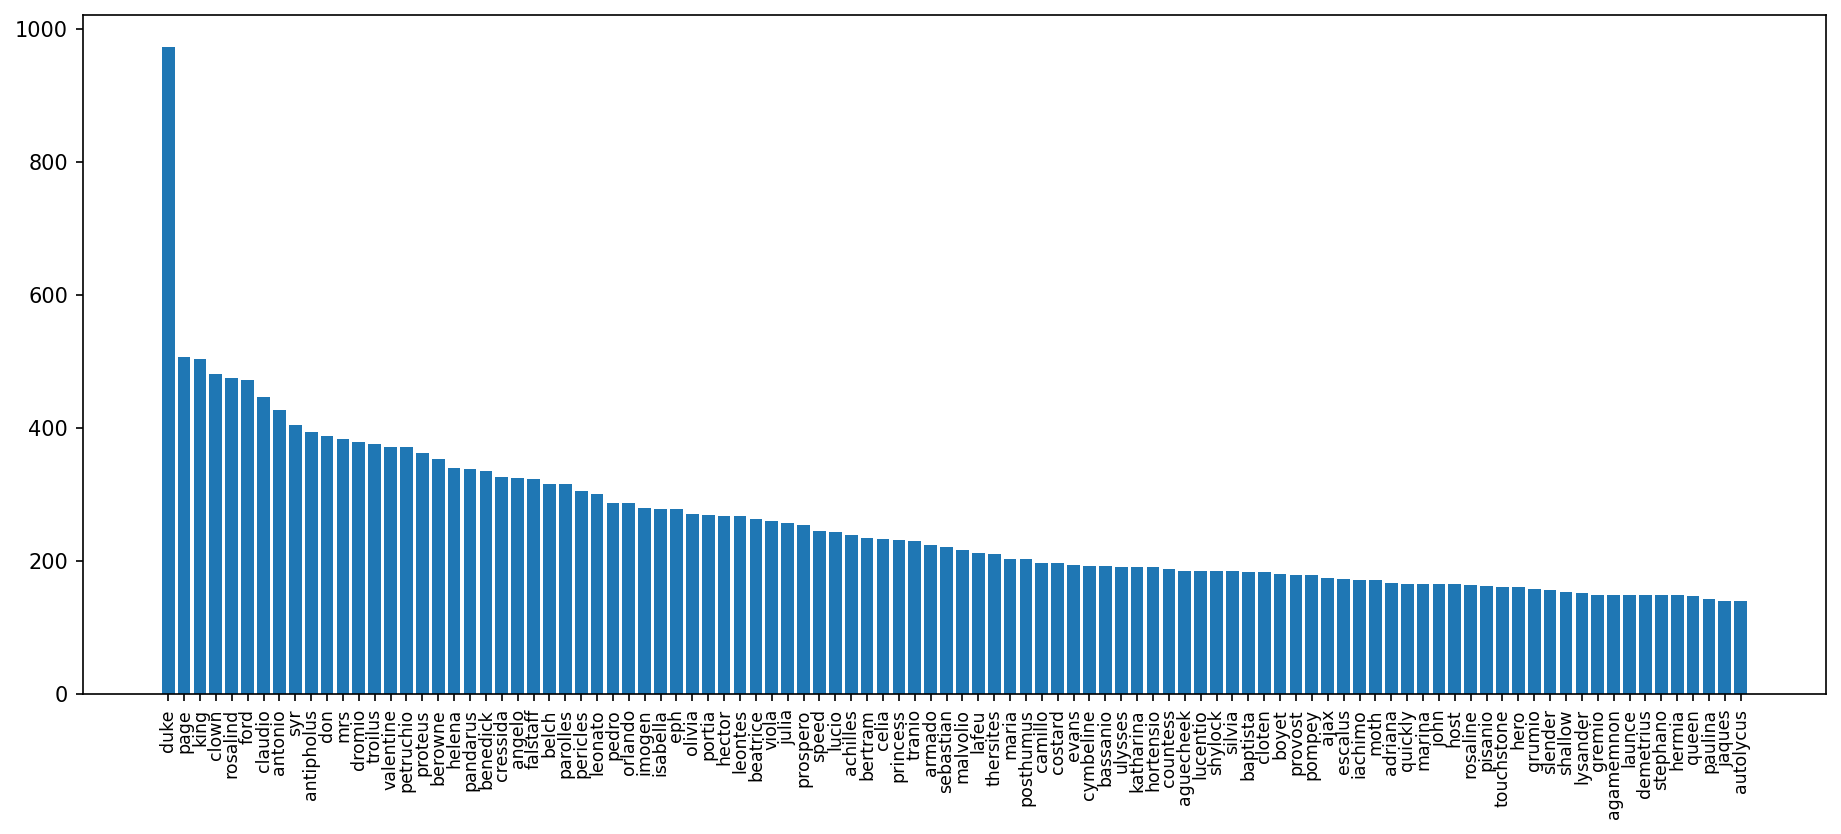

In [23]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

data = for_histogrom_rdd.map(lambda x: x[0]).take(100)
labels = for_histogrom_rdd.map(lambda x: x[1]).take(100)

figure(figsize=(15, 6), dpi=150)
plt.bar(range(len(labels)), labels)
plt.xticks(range(len(data)), data, rotation='vertical', size='small')
plt.show()

## Computing the cosine similarity


1. I need the term presence in the document, rather that the number of occurences. 
2. My rows are not made of 17 numbers. **SUPER IMPORTANT!**
2. Compute the similarity only for the non-zero rows